In [255]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, utils
from tensorflow.keras.preprocessing import text, sequence

In [3]:
data_path = '/Users/akshay/Dropbox/Personal/Data Science/Codes/Projects Non Git/MovieLens/'
filenames = [f for r,d,f in os.walk(data_path)][0]
filepaths = [data_path+f for f in filenames if f[-4:]=='.csv']
filepaths

['/Users/akshay/Dropbox/Personal/Data Science/Codes/Projects Non Git/MovieLens/links.csv',
 '/Users/akshay/Dropbox/Personal/Data Science/Codes/Projects Non Git/MovieLens/tags.csv',
 '/Users/akshay/Dropbox/Personal/Data Science/Codes/Projects Non Git/MovieLens/ratings.csv',
 '/Users/akshay/Dropbox/Personal/Data Science/Codes/Projects Non Git/MovieLens/movies.csv']

In [6]:
#links = pd.read_csv(filepaths[0])
#tags = pd.read_csv(filepaths[1])
ratings = pd.read_csv(filepaths[2])
movies = pd.read_csv(filepaths[3])

In [13]:
#movies -> title(string), year, genres(list)
#ratings -> rating, timestamp
#tags -> tag(list)

In [156]:
def namefix(s):
    c = [i[:-1] for i in s.split('(')]
    return re.sub('[^A-Za-z0-9 ]+', '', c[0].lower())

In [157]:
movies['name'] = movies['title'].apply(namefix)

In [158]:
genres = pd.get_dummies(pd.DataFrame(movies['genres']\
                                     .apply(str.split, args='|')\
                                     .explode()), prefix='', prefix_sep='')\
                                     .groupby(level=0)\
                                     .sum()

In [183]:
tok = text.Tokenizer(num_words=5000)
tok.fit_on_texts(movies['name'])
seq = tok.texts_to_sequences(movies['name'])
seq = sequence.pad_sequences(seq, padding='post', maxlen=14)

In [185]:
a = ratings[['userId', 'movieId', 'rating']]
b = movies[['movieId']]
c = genres
d = pd.DataFrame(seq)

data = pd.merge(a, b.join(c).join(d), on='movieId', how='left')

In [186]:
y = data['rating']
X = data.drop(['rating'], axis=1)
X

,userId,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,4,5,6,7,8,9,10,11,12,13
0,1,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,47,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,50,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100832,610,168248,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
100833,610,168250,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100834,610,168252,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, shuffle=True)
[i.shape for i in [X_train, X_test, y_train, y_test]]

[(80668, 36), (20168, 36), (80668,), (20168,)]

In [252]:
#CREATE CONFIGURATION FOR FIELDS

field_dict = {'name':['userID', 'movieID','genres','name'],
              'length':[1, 1, c.shape[1], d.shape[1]],
              'type':['cat', 'cat', 'hot', 'seq'],
              'embdim':[X['userId'].nunique(), X['movieId'].nunique(), c.shape[1], len(tok.word_index)+1]}
pd.DataFrame(field_dict)

,name,length,type,embdim
0,userID,1,cat,610
1,movieID,1,cat,9724
2,genres,20,hot,20
3,name,14,seq,7765


In [244]:
#Get field mask

z = [0]+list(np.cumsum(field_dict['length']))
field_mask = [slice(s,t) for s,t in zip(z, z[1:])]
field_mask

[slice(0, 1, None), slice(1, 2, None), slice(2, 22, None), slice(22, 36, None)]

In [262]:
fields = []
embeddings = []

inp = layers.Input((36,))

for i in field_mask:
    lmd = layers.Lambda(lambda x: x[:,i])(inp)
    fields.append(lmd)   
    
for i,j in enumerate(zip(field_dict['embdim'], field_dict['type'])):
    if j[1]=='cat':
        x = layers.Embedding(j[0], 15)(fields[i])   #(None, 1, 15)
        x = layers.Reshape((15,))(x)                #(None, 15)
        embeddings.append(x)
        
    if j[1] in ('num', 'hot'):
        x = layers.Dense(15)(fields[i])             #(None, 15)
        embeddings.append(x)
    
    if j[1]=='seq':
        x = layers.Embedding(j[0]+1, 10)(fields[i]) #(None, 14, 10) 
        x = layers.LSTM(15)(x)                      #(None, 15)
        embeddings.append(x)

x = layers.concatenate(embeddings)

model = Model(inp, x)
model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 36)]         0                                            
__________________________________________________________________________________________________
lambda_52 (Lambda)              (None, 1)            0           input_16[0][0]                   
__________________________________________________________________________________________________
lambda_53 (Lambda)              (None, 1)            0           input_16[0][0]                   
__________________________________________________________________________________________________
lambda_55 (Lambda)              (None, 14)           0           input_16[0][0]                   
______________________________________________________________________________________

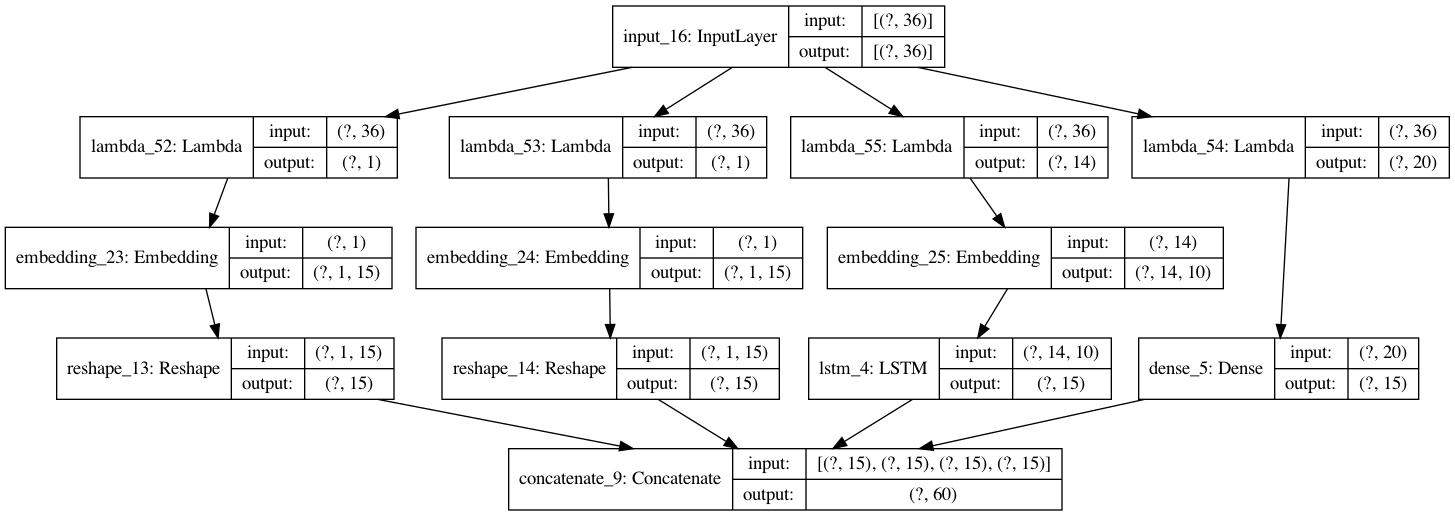

In [263]:
utils.plot_model(model, show_shapes=True)